![](./figures/Logo.PNG)

# 4 a - History Matching coding exercise hints

---

**Set current working directory and import python modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import sys
import seaborn as sns
import matplotlib.dates as mdate
sys.path.append('src/')
from sampling import AAT_sampling # module to perform the input sampling

import HyMod

**Load data, prepare input data**

In [2]:
# Read catchment data
catchment_names = ["Pere Marquette River, MI, USA", "Trout River, BC, Canada", 
                   "Siletz River, OR, USA", "Medina River, TX, USA",
                   "South Branch Potomac River, USA", "Bad River, Wisconsin, USA"]
catchment_name = catchment_names[5]
file_dic = {catchment_names[0]: "camels_04122500", catchment_names[1]: "hysets_10BE007", 
            catchment_names[2]: "camels_14305500", catchment_names[3]: "camels_08178880",
            catchment_names[4]: "camels_01605500", catchment_names[5]: "camels_04027000"}
df_obs = pd.read_csv(f"data/{file_dic[catchment_name]}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Index frame by date
df_obs.set_index('date', inplace=True)
# Select time frame
start_date = '2005-01-01'
end_date = '2006-12-31'
df_obs = df_obs[start_date:end_date]
n_days = 365  # days for the model to spin-up (fill with water)
# Reformat the date for plotting
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
# Reindex
df_obs = df_obs.reset_index(drop=True)
# Select snow, precip, PET, streamflow and T
df_obs = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean", "date"]]
# Rename variables
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# Extract time series
P = df_obs["P [mm/day]"].to_numpy()
pet = df_obs["PET [mm/day]"].to_numpy()
#temp = df_obs["T [C]"].to_numpy()
Q_obs = df_obs["Q [mm/day]"].to_numpy()

# Number of uncertain parameters subject to SA:
M = 5

# Parameter ranges:
xmin = [1, 0, 0, 8, 1]
xmax = [400, 2, 1, 200, 7]

# Parameter distributions:
distr_fun = st.uniform # uniform distribution
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Name of parameters (will be used to customize plots):
parameter_names = ['Sm', 'beta', 'alfa', 'Rs', 'Rf']

samp_strat = "lhs"  # Latin Hypercube sampling

**History matching**

Running the model 800 times: 80 parameter sets, varying precipitation 10 times
Plotting plausible runoff and observations


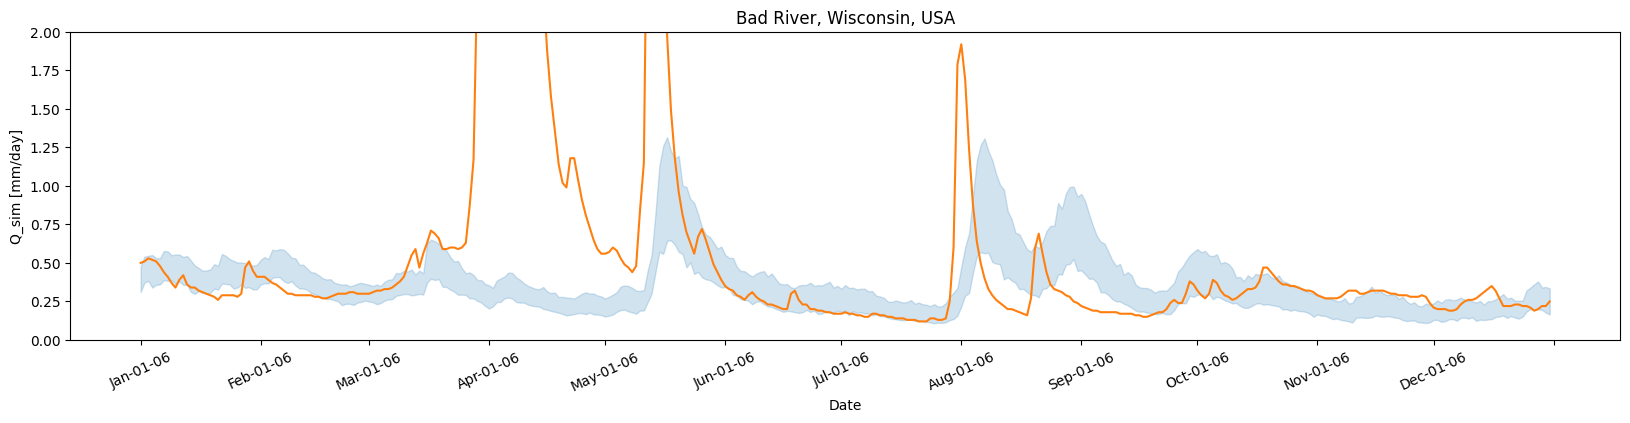

In [3]:
try:
    # Set number of sample sets
    N_samples = 80
    # Set precipitation ensemble size 
    N_precip = 10
    # Set minimum of precipitation multiplier (e.g. 0.8)
    multiplier_min = 0.8
    # Set maximum of precipitation multiplier (e.g. 1.2)
    multiplier_max = 1.2
    # Set threshold for implausibility (e.g. 3)
    implausibility_threshold = 3
    print(f"Running the model {N_samples*N_precip} times: {N_samples} parameter sets, varying precipitation {N_precip} times")

    # Sample parameter sets using AAT_sampling (using random uniform sampling - "rsu")
    parameter_sets = AAT_sampling("rsu", M, distr_fun, distr_par, N_samples)  # "rsu": code for random uniform sampling

    # Create two empty lists where we collect plausible parameter sets and plausible simulation outputs (runoff)
    l_plausible_parameter_sets = []  # [1]
    l_Q_sims_plausible = []  # [2]
    # loop through the parameter sets
    for parameter_set in parameter_sets:
        # create empty list where we collect the simulated runoff for current parameter set, with varied precipitation
        l_Q_sim_with_varied_precip = [] # [3]
        # Create precipitation multipliers between min and max (size=N_precip). 
        # You can use np.random.uniform(), check the docu to learn how to use it
        precip_multipliers = np.random.uniform(low=multiplier_min, high=multiplier_max, size=N_precip)
        # loop throguh precipitation multipliers
        for precip_multiplier in precip_multipliers:
            # prepare parameters for the HyMod implementation: 1/Rf and 1/Rs, the other parameters stay the same
            param = np.array([parameter_set[0], parameter_set[1], parameter_set[2], 1/parameter_set[3], 1/parameter_set[4]])
            # multiply precipitation with the current multiplier
            P_multiplied = P * precip_multiplier
            # run HyMod using the multiplied precipitation data ( Q, states, fluxes = HyMod.hymod_sim(param, P_multiplied, pet) )
            Q_sim_with_varied_precip, states, fluxes = HyMod.hymod_sim(param, P_multiplied, pet)
            # append resulting simulated runoff for current parameter set with current precipitation to empty list defined above: at [3]
            l_Q_sim_with_varied_precip.append(Q_sim_with_varied_precip[n_days:])
        # use np.array() to transform list from [3] to numpy array
        Q_sims_with_varied_precip = np.array(l_Q_sim_with_varied_precip)
        # calculate the expected value of the simulated runoff for different precipitation data. You can use np.mean. 
        # Make sure you choose the right axis to compute the mean along: the result should have the length of simulated timesteps (365 days)
        expected_value_sims = np.mean( Q_sims_with_varied_precip, axis=0 )
        # Calculate the mean of the residuals of each timestep using the expected value and Q_obs[n_days:]. 
        # [n_days:] is used to crop the Q_obs data to the evaluation period 
        residual = np.mean( np.subtract( expected_value_sims, Q_obs[n_days:] ) )
        # Calculate the mean of the square root of the variance. 
        # You can use np.mean(npsqrt(np.var(<variable>))) 
        variance = np.mean( np.sqrt( np.var(Q_sims_with_varied_precip) ) )

        # Calculate the implausibility: divide the residual by the variance
        implausibility = np.divide( residual,  variance )
        #print(implausibility)
        # Check whether implausibility is too large for this parameter set  
        if implausibility < implausibility_threshold:
            # if plausible: append expected value of the simulated runoff for different precipitation data to list [2] and...
            l_Q_sims_plausible.append(expected_value_sims)
            # ... the parameter set that got plausible results to list [1]
            l_plausible_parameter_sets.append(parameter_set)

    # Transform list to array (np.array()), transpose array (.T) and make a DataFrame of the result (pd.DataFrame)
    df_Q_sims_plausible = pd.DataFrame(np.array(l_Q_sims_plausible).T)

    # Plotting
    df_obs_eval = df_obs[n_days:]
    # Add date column to plausible data
    df_Q_sims_plausible["Date"] = df_obs["Date"].to_numpy()[n_days:]
    # Set date as index. This way, each column will be associated with the date when we melt the dataframe in the next step
    df_Q_sims_plausible = df_Q_sims_plausible.set_index("Date")
    # Data is in multiple columns (one for each plausible parameter set), but for plotting we need it in one column
    # We do not ignore the index in melt so that the date will remain associated with the respective runoffs of the plausible parameter sets
    df_Q_sims_plausible = df_Q_sims_plausible.melt(var_name="parameter set id", value_name="Q_sim [mm/day]", ignore_index=False)
    # Set index (is currently the date) as column
    df_Q_sims_plausible = df_Q_sims_plausible.reset_index()
    #print(f"df_Q_sims_plausible: {df_Q_sims_plausible}")    
    
    print("Plotting plausible runoff and observations")
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    sns.lineplot(df_Q_sims_plausible, x="Date", y="Q_sim [mm/day]", linewidth=0, errorbar=("ci", 100))
    sns.lineplot(df_obs[n_days:], x="Date", y="Q [mm/day]")
    
    # Show only the main ticks
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    ax.set_title(catchment_name)
    plt.xticks(rotation=25)
    plt.ylim(bottom=0, top=2)  # you may set y limits to get a clearer view on the hydrograph
    plt.show()
    
except Exception as error:
    print("An error occurred:", error)

---

## Jupyter format settings

In [4]:
%%html 
<style>.blue {background-color: #8dc9fc;}</style>